# Sensor placement on images of faces

This is an implementation of the sensor placement algorithm described in the [paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8361090&casa_token=CFyIUydrDngAAAAA:B0Vh4rY6HxGuKVl1QWfEEPhsPnl9Nv2CE6Za4RtzYaQ2U59v4iS2FhBx8cqG4fGeEZorKOr33qc&tag=1) on "Data-Driven Sparse Sensor Placement for Reconstruction".





![./figs/sensor_placement_main_eq.jpg](./figs/sensor_placement_main_eq.jpg)

The goal is to find the best matrices $C$ and $\Psi_r$ so that the reconstruction of the full data is as close to the original as possible. 

$C$ is a matrix representing which data points that are to be measured, i.e the sensor placement. It is a sparse matrix with a single 1 per row. Where this 1 is placed represents which part of the full data vector that is measured by the sensor represented by that row. 

$\Psi_r$ is a matrix that is a taylored basis for the data set. In this case it is found by POD. 

If one has found a $C$ and $\Psi_r$ matrix one can find an estimate of the full data from only the sparse measurements in $y$. 

$X$ is the full data. 

Using the POD $X$ is decomposed: $X \approx \Psi_r S_r V_r^T$.

$x$ is a single data point. And can be similarly decomposed using the basis of the full data set: $x \approx \Psi_r a$

$y = C x$

$y \approx C \Psi_r a = \Theta a$

$\hat a = \Theta^{\dagger} y$ 

Finding an estimate of a we can find an estimate of $x$ using $\Psi_r$

$\hat x = \Psi_r \hat a = \Psi_r (C \Psi_r)^{\dagger} y = \Psi_r (C \Psi_r)^{\dagger} C x$

All one needs now to find a way to reconstruct data from sparse measurements is to find a good decomposition of the data $\Psi_r$ and a good sensor placement $C$.


### Mathematics for the error in reconstruction:  

$X = U S V^T = \Psi_r A_r + E_r$

$Y = C X = C (\Psi_r A_r + E_r)$

$\Theta = C \Psi_r$

$\hat X = \Psi_r (C \Psi_r)^{\dagger} Y = \Psi_r (C \Psi_r)^{\dagger} C (\Psi_r A_r + E_r)$

$\hat X =  \Psi_r (C \Psi_r)^{\dagger} (C\Psi_r) A_r  + \Psi_r (C \Psi_r)^{\dagger} C E_r$

$\hat X = \Psi_r A_r +  \Psi_r (C \Psi_r)^{\dagger} C E_r = X - E_r + \Psi_r (C \Psi_r)^{\dagger} C E_r$

$\hat X - X = (\Psi_r (C \Psi_r)^{\dagger} C - I) E_r$

The reconstruction error is the decomposition error $E_r$ times how close the matrix $\Psi_r (C \Psi_r)^{\dagger} C$ is to the identity. 





In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import scipy.linalg

In [2]:
#Loading data
mat = scipy.io.loadmat('../data/Yale_32x32.mat')
X = mat['fea'].T

In [3]:
# Choose parameters for the sensor placement
# POD components
n_POD_components = 50

# Number of sensors
# Number of sensors has to be larger or equal to the number of POD components
n_sensors = 50

In [4]:
# Function for finding first n POD components using svd
def calculate_POD(X, n, mean_centering=True):
    if mean_centering:
        X_mean = np.mean(X, axis=1, keepdims=True) 
        X_ = X - np.tile(X_mean,(1,X.shape[1]))
    else:
        X_ = X
        X_mean = np.zeros((X.shape[0],1))
    U, S, V = np.linalg.svd(X_)
    Psi_r = U[:,:n]
       
    return Psi_r, X_mean

In [5]:
# Finding POD basis (Psi_r)
Psi_r, X_mean  = calculate_POD(X, n_POD_components)


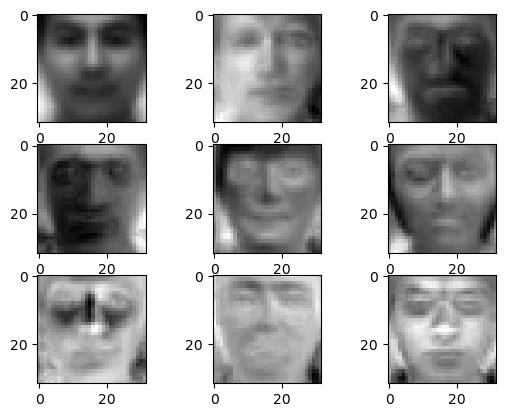

In [6]:
# Showing the mean and the first 10 POD components
plt.subplot(3,3,1)
plt.imshow(X_mean.reshape(32,32).T, cmap="gray")
for i in range(8):
    plt.subplot(3,3, i+2)
    plt.imshow(Psi_r[:,i].reshape(32,32).T, cmap="gray")
plt.show()

In [7]:
# Functions for finding optimal sensor placement 
def qr_pivots(Psi_r, num_eigen, num_sensors=None):
    if num_sensors is None:
        num_sensors = num_eigen
    
    M = Psi_r.T
    if num_sensors > num_eigen:
        M = Psi_r @  Psi_r.T

    Q, R, P = scipy.linalg.qr(M, pivoting=True)
    return P

def find_sensor_placement(Psi_r, num_eigen, num_sensors=None):
    P = qr_pivots(Psi_r, num_eigen, num_sensors)
    C = np.zeros((num_sensors,Psi_r.shape[0]))
    C[np.arange(num_sensors),P[:num_sensors]] = 1
    return C

In [8]:
# Finding the sensor placement matrix C
C = find_sensor_placement(Psi_r, n_POD_components, n_sensors)

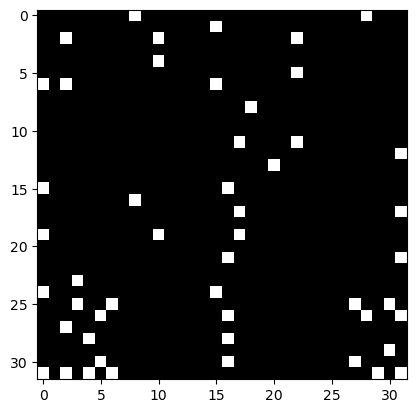

In [9]:
# Showing the sensor placement
plt.imshow(np.sum(C, axis=0).reshape(32,32).T, cmap='gray')
plt.show()
# The white pixels are the pixels in the image where one measures the image

In [10]:
Theta = C @ Psi_r
Theta_inv = np.linalg.pinv(Theta)

In [11]:
def create_measurements_sensor_placement(X, C, X_mean):
    Y = np.dot(C, (X - np.tile(X_mean,(1,X.shape[1]))))
    return Y


In [12]:
Y = create_measurements_sensor_placement(X, C, X_mean)

In [13]:

def reconstruct_from_measurements(Y, C, Psi_r, X_mean,Theta_inv = None):
    if Theta_inv is None:
        Theta_inv = np.linalg.inv(np.dot(C, Psi_r))
    X_hat = np.dot(Psi_r, np.dot(Theta_inv, Y)) + np.tile(X_mean,(1,Y.shape[1]))
    return X_hat

In [14]:
X_hat = reconstruct_from_measurements(Y, C, Psi_r, X_mean, Theta_inv)

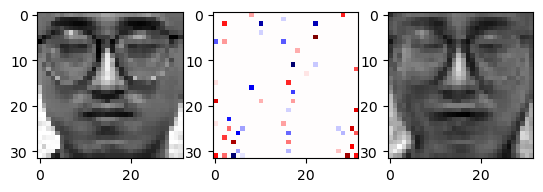

In [20]:
# Show image measurement and reconstruction of face image
image_index = np.random.choice(X.shape[1])
plt.subplot(1,3,1)
plt.imshow(X[:,image_index].reshape(32,32).T, cmap="gray")
plt.subplot(1,3,2)
y_image = (Y[:,image_index]*C.T).T.sum(axis=0).reshape(32,32).T
y_max = np.max(np.abs(y_image))
plt.imshow(y_image, cmap="seismic", vmin=-y_max, vmax=y_max)
plt.subplot(1,3,3)
plt.imshow(X_hat[:,image_index].reshape(32,32).T, cmap="gray")

plt.show()